Using device: mps
Model aggregation complete.



Finance (Chatbot) Test Metrics:
Loss: 0.1738
Accuracy: 0.9389
Precision: 0.9553
Recall: 0.9144
F1 Score: 0.9344


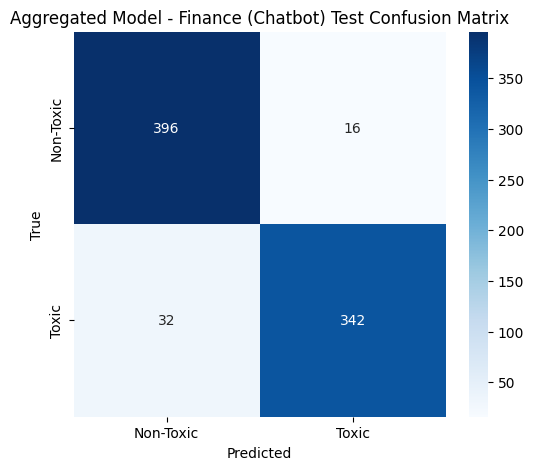


Social Media Test Metrics:
Loss: 0.9206
Accuracy: 0.7226
Precision: 0.6488
Recall: 0.9798
F1 Score: 0.7807


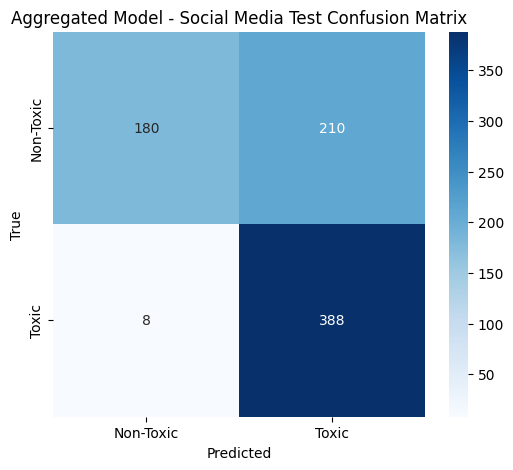

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# -----------------------------------------------------------------------------
# Global Setup
# -----------------------------------------------------------------------------

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
print("Using device:", device)

# Load tokenizer (same one used during training)
tokenizer = AutoTokenizer.from_pretrained("JungleLee/bert-toxic-comment-classification")

# -----------------------------------------------------------------------------
# Helper Classes & Functions
# -----------------------------------------------------------------------------

class TextDataset(Dataset):
    """
    Torch Dataset for text classification data.
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def load_data(file_path):
    """
    Loads data from a CSV file with columns 'cleaned_text' and 'label'.
    """
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['cleaned_text', 'label'])
    data['cleaned_text'] = data['cleaned_text'].astype(str)
    return data["cleaned_text"].tolist(), data["label"].tolist()

def create_dataloader(texts, labels, tokenizer, batch_size=8, shuffle=False):
    dataset = TextDataset(texts, labels, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def get_model():
    """
    Returns a new instance of the model architecture.
    """
    return AutoModelForSequenceClassification.from_pretrained("JungleLee/bert-toxic-comment-classification")

def aggregate_models(model1, model2):
    """
    Aggregates two models by combining their parameters elementwise such that if at least one model 
    leans "toxic" (i.e. has a positive parameter), the aggregated parameter is positive.
    
    For each parameter:
      - Compute the sign: +1 if > 0, -1 otherwise.
      - The aggregated sign is the maximum of the two signs.
      - The magnitude is the average of the absolute values.
    """
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    aggregated_state_dict = {}

    for key in state_dict1.keys():
        param1 = state_dict1[key]
        param2 = state_dict2[key]
        
        # Determine sign: +1 if parameter > 0, -1 otherwise.
        s1 = (param1 > 0).float() * 2 - 1
        s2 = (param2 > 0).float() * 2 - 1
        
        # If either parameter is positive, choose +1; otherwise, -1.
        aggregated_sign = torch.max(s1, s2)
        
        # Average the magnitudes.
        magnitude = 0.5 * (torch.abs(param1) + torch.abs(param2))
        
        aggregated_state_dict[key] = aggregated_sign * magnitude

    # Create a new model instance and load the aggregated state dictionary.
    aggregated_model = get_model().to(device)
    aggregated_model.load_state_dict(aggregated_state_dict)
    return aggregated_model

def evaluate(model, dataloader, device):
    """
    Evaluates the model on the given test set and returns loss and classification metrics.
    """
    model.eval()
    test_losses = []
    test_labels_list = []
    test_preds_list = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Testing", leave=False)
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_losses.append(loss.item())

            preds = torch.argmax(outputs.logits, dim=1)
            test_labels_list.extend(labels.cpu().numpy())
            test_preds_list.extend(preds.cpu().numpy())

    average_loss = np.mean(test_losses)
    accuracy = accuracy_score(test_labels_list, test_preds_list)
    precision = precision_score(test_labels_list, test_preds_list, zero_division=0)
    recall = recall_score(test_labels_list, test_preds_list, zero_division=0)
    f1 = f1_score(test_labels_list, test_preds_list, zero_division=0)
    
    return average_loss, accuracy, precision, recall, f1, test_labels_list, test_preds_list

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# -----------------------------------------------------------------------------
# Load Saved Models and Aggregate
# -----------------------------------------------------------------------------

# Load the fine-tuned models from saved directories.
model_chatbot = AutoModelForSequenceClassification.from_pretrained("bert_finance").to(device)
model_social  = AutoModelForSequenceClassification.from_pretrained("bert_soical").to(device)

# Aggregate the models.
aggregated_model = aggregate_models(model_chatbot, model_social)
print("Model aggregation complete.")

# -----------------------------------------------------------------------------
# Evaluate on Finance (Chatbot) Test Set
# -----------------------------------------------------------------------------

chatbot_test_texts, chatbot_test_labels = load_data("chatbot_final_data_test.csv")
chatbot_test_dataloader = create_dataloader(chatbot_test_texts, chatbot_test_labels, tokenizer, batch_size=8, shuffle=False)

avg_loss_finance, acc_finance, prec_finance, rec_finance, f1_finance, y_true_finance, y_pred_finance = evaluate(aggregated_model, chatbot_test_dataloader, device)

print("\nFinance (Chatbot) Test Metrics:")
print(f"Loss: {avg_loss_finance:.4f}")
print(f"Accuracy: {acc_finance:.4f}")
print(f"Precision: {prec_finance:.4f}")
print(f"Recall: {rec_finance:.4f}")
print(f"F1 Score: {f1_finance:.4f}")

plot_confusion_matrix(y_true_finance, y_pred_finance, classes=['Non-Toxic', 'Toxic'], 
                      title="Aggregated Model - Finance (Chatbot) Test Confusion Matrix")

# -----------------------------------------------------------------------------
# Evaluate on Social Media Test Set
# -----------------------------------------------------------------------------

social_test_texts, social_test_labels = load_data("social_media_final_data_test.csv")
social_test_dataloader = create_dataloader(social_test_texts, social_test_labels, tokenizer, batch_size=8, shuffle=False)

avg_loss_social, acc_social, prec_social, rec_social, f1_social, y_true_social, y_pred_social = evaluate(aggregated_model, social_test_dataloader, device)

print("\nSocial Media Test Metrics:")
print(f"Loss: {avg_loss_social:.4f}")
print(f"Accuracy: {acc_social:.4f}")
print(f"Precision: {prec_social:.4f}")
print(f"Recall: {rec_social:.4f}")
print(f"F1 Score: {f1_social:.4f}")

plot_confusion_matrix(y_true_social, y_pred_social, classes=['Non-Toxic', 'Toxic'], 
                      title="Aggregated Model - Social Media Test Confusion Matrix")
